# Baseline 2:

Staged Least Squares Instrumental Variables Regression using Cornelia's Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

#### 11-15-22 Things we want
* Trevor, can you add p-values to all Step 3 functions?
* discuss fixed effects we want to include
* discuss which windows to run

---
### Step 0: Specify Inputs/Outputs

In [1352]:
# ['central_wind_alignment_180_high',
#  'new_alignment_90_high',
#  'Izmy_v1_unnormed',
#  'Izmy_v2_nodist_unnormed',
#  'Izmy_v3_normed_D_and_TPY',
#  'Izmy_v4_nodist_normed_TPY',
#  'Izmy_v5_all_normed_but_wspd_ratio'
#  'Izmy_v6_unnormed_no_wspd',
#  'Izmy_v7_all_normed_no_wspd',
#  'Izmy_v8_normed_D_and_TPY_no_wspd'
# ]

predictor = 'Izmy_v5_all_normed_but_wspd_ratio'
lead_time = 9
lag_time = '3'
lag_style = 'fwd'

adds = ''
# adds = '+ ca_agi_per_returns + school_count + total_population + avg_count_ps_within_5km'
# adds = '+ ca_agi_per_returns + school_count'
#vadds = '+ school_count'
# adds = '+ total_population'
# adds = '+ school_count + total_population'
# adds = '+ school_count + avg_count_ps_within_5km'
# adds = '+ total_population + avg_count_ps_within_5km'
# adds = '+ ca_agi_per_returns + school_count + total_population'
# adds = '+ ca_agi_per_returns + school_count + avg_count_ps_within_5km'
# adds = '+ ca_agi_per_returns + total_population + avg_count_ps_within_5km'
# adds = '+ school_count + total_population + avg_count_ps_within_5km'
adds = '+ ca_agi_per_returns + avg_count_ps_within_5km'
# adds = ' + ca_agi_per_returns + total_population'
# adds = '+ avg_count_ps_within_5km' 


---
### Step 1: Import packages

In [1353]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.stats.anova import anova_lm

import patsy
import sklearn.preprocessing as sklp
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

---
### Step 2: Define working directories

In [1354]:
# in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
# in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'

in_dir_sc = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\'
in_dir_h = 'C:\\Users\\matts\\Documents\\Berkeley MIDS\\DataSci 210 Capstone\\non-push files\\data\\medical\\'

# in_dir_sc = '/Users/michelle/MIDS/210 Capstone/data/'
# in_dir_h = '/Users/michelle/MIDS/210 Capstone/output/'

---
### Step 3: Define functions

In [1355]:
def fit_ols(df, outcome, predictor):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)

    # determine whether to include wind in FEs based on instrument
    wind_map = set('Izmy_v' + str(i + 1) for i in range(5))
    include_wind = predictor[:7] not in wind_map

    # create FE and interactions between FE and continous vars
    wind = ""
    
    if include_wind:
        wind = '+ avg_wspd_top_15_r' + str(lead_time)
    
    basics = " ~ county + month + year_trend * C(county_month)"
    env = '+ avg_temp_r' + str(lead_time) + '+ avg_elevation_diff_m'
    
    f = outcome + basics + wind + env + adds
    
    # create FE and interactions between FE and continous vars
    f = outcome + " ~ county + month + year_trend * C(county_month)"
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    # X = temp[['pm25']]
    X = temp[[predictor]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    # display estimates
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            ##### Trevor pls #####
            # pd.DataFrame(model_a.pvalues[0])
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:]
        ],
        axis=1
    ))

In [1356]:
def fit_1st_stage(df, pm_col, instr_col, lead_time):
    ''' First stage to check whether wfeI is a strong instrument for pm25I
    '''
    
    def get_ols_res(fitted):
      fit_res = fitted.params.to_frame().reset_index()
      fit_res.columns = ['variable', 'coef']
      fit_res['p_value'] = fitted.pvalues.values
      df_ci = fitted.conf_int().reset_index()
      df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
      fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
      return fit_res
    
    temp = df.copy()
    
    # determine whether to include wind in FEs based on instrument
    wind_map = set('Izmy_v' + str(i + 1) for i in range(5))
    include_wind = predictor[:7] not in wind_map

    # create FE and interactions between FE and continous vars
    wind = ""
    
    if include_wind:
        wind = '+ avg_wspd_top_15_r' + str(lead_time)
    
    basics = " ~ county + month + year_trend * C(county_month)"
    env = '+ avg_temp_r' + str(lead_time) + '+ avg_elevation_diff_m'
    
    f = pm_col + basics + wind + env + adds
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    X = temp[[instr_col]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    fit_1st_stage = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    temp['yhat_pm25'] = fit_1st_stage.fittedvalues.values
    
    # calculate r^2
    ss_resid = sum((temp['yhat_pm25'].values - temp[pm_col].values)**2)
    ss_total = sum((temp[pm_col].mean() - temp[pm_col].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    # display estimates
    print('Outcome: ', pm_col)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(fit_1st_stage.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(fit_1st_stage.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            fit_1st_stage.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    print('R Squared:', r_squared)
    print("p =",get_ols_res(fit_1st_stage).loc[0][2])
    print()
    
    # save pm25I_hat
    temp[pm_col+'_hat'] = fit_1st_stage.get_prediction(X).summary_frame()['mean']

    return temp

In [1357]:
def fit_2sls(df, outcome, independent_var_name='pm25_hat', lead_time=9):
    ''''''
    # drop if outcome is nan
    temp = df[~df[outcome].isna()]
    temp.reset_index(drop=True, inplace=True)
    
    def get_ols_res(fitted):
      fit_res = fitted.params.to_frame().reset_index()
      fit_res.columns = ['variable', 'coef']
      fit_res['p_value'] = fitted.pvalues.values
      df_ci = fitted.conf_int().reset_index()
      df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
      fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
      return fit_res

    # determine whether to include wind in FEs based on instrument
    wind_map = set('Izmy_v' + str(i + 1) for i in range(5))
    include_wind = predictor[:7] not in wind_map

    # create FE and interactions between FE and continous vars
    wind = ""

    if include_wind:
        wind = '+ avg_wspd_top_15_r' + str(lead_time)

    basics = " ~ county + month + year_trend * C(county_month)"
    env = '+ avg_temp_r' + str(lead_time) + '+ avg_elevation_diff_m'

    f = outcome + basics + wind + env + adds
    print(f)
    y, X_fe = patsy.dmatrices(f, temp, return_type="dataframe")
    
    #X = temp[['pm25_hat']]
    X = temp[[independent_var_name]]
    
    # concat
    X = pd.concat([X, X_fe], axis=1)

    # fit model
    model_a = sm.OLS(y, X).fit(
        cov_type='cluster',
        cov_kwds={'groups':temp['county']},
        use_t=True
    )
    
    temp[independent_var_name] = model_a.fittedvalues.values
    
    # calculate r^2
    ss_resid = sum((temp[independent_var_name].values - temp[outcome].values)**2)
    ss_total = sum((temp[outcome].mean() - temp[outcome].values)**2)
    r_squared = 1 - ss_resid / ss_total 
    
    # display estimates
    print('-------------------------------------')
    print('Outcome: ', outcome)
    print('-------------------------------------')
    display(pd.concat(
        [
            pd.DataFrame(model_a.params).reset_index(drop=False).rename(columns={"index":"variable", 0:"coef"}).iloc[0:2,:],
            pd.DataFrame(model_a.bse).reset_index(drop=False).rename(columns={"index":"variable", 0:"std err"}).iloc[0:2,1:2],
            model_a.conf_int(alpha=0.05, cols=None).reset_index(drop=True).rename(columns={0:"[0.025", 1:"0.975]"}).iloc[0:2,:]
        ],
        axis=1
    ))
    
    print('R Squared:', r_squared)
    print("p =",get_ols_res(model_a).loc[0][2])
    print()

---
### Step 4: Read and clean data

#### 4.1. Function to generate rolling windows on dataframe (lead)

In [1358]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed']
    ,rolling_periods:list = [9]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = rolling_periods

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int


#### 4.2. Read in non-medical data and medical data
* Generate rolling windows for non-medical data for instrumental variable
* Filter out 2018 data from both non-medica and medical data

In [1359]:
# non-medical data
for file in os.listdir(in_dir_sc):
    if file.startswith('modeling'):
        # read in our modeling data
        df_sc = pd.read_csv(os.path.join(in_dir_sc, file))

# add key to df
df_sc['patzip_year_month'] = df_sc.school_zip.astype(str) + '-' + df_sc.year.astype(str) + '-' + df_sc.month.astype(str)

# add instrumental variables rolling things here - looking at past data, so need 2000-2002 for previous avgs
cols_to_roll = ['central_wind_alignment_180_high',
 'new_alignment_90_high',
 'Izmy_v1_unnormed',
 'Izmy_v2_nodist_unnormed',
 'Izmy_v3_normed_D_and_TPY',
 'Izmy_v4_nodist_normed_TPY',
 'Izmy_v5_all_normed_but_wspd_ratio',
 'Izmy_v6_unnormed_no_wspd',
 'Izmy_v7_all_normed_no_wspd',
 'Izmy_v8_normed_D_and_TPY_no_wspd',
'avg_wspd_top_15',
'avg_temp']

rolling_periods = [lead_time]
df_sc, all_cols = roll_selected_cols(df=df_sc, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# drop if year >=2018
df_sc = df_sc[df_sc.year.le(2017)]

# print shape of data
print('Shape of data ', df_sc.shape)
df_sc.head(2)

Shape of data  (294897, 162)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [1360]:
display(df_sc)

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [1361]:
# medical data
df_h = pd.DataFrame()
df_h['patzip_year_month'] = df_sc.patzip_year_month.unique()

for file in os.listdir(in_dir_h):
    # read in cornelia's healthcare data
    temp = pd.read_csv(os.path.join(in_dir_h, file)).iloc[:,1:]
    # rename number_of_visits column
    temp.rename(
        columns={'number_of_visits':'visits_'+file.split('.')[0]},
        inplace=True
    )

    # merge to df_h
    df_h = df_h.merge(
        temp[['patzip_year_month', 'visits_'+file.split('.')[0]]],
        on='patzip_year_month',
        how='left'
    )

# Filter out 2018 data bc it's all nulls 
# if year > 2017, drop
df_h['year_h'] = df_h.patzip_year_month.str.split('-').str[1]
df_h = df_h[df_h.year_h.le('2017')]
df_h.drop(columns='year_h', inplace=True)

# print shape of data
print('Shape of data ', df_h.shape)
df_h[~df_h.visits_resp_cardio.isna()].head(2)

Shape of data  (294897, 6)


,patzip_year_month,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes
35905,91214-2000-5,NaN,NaN,NaN,112.0,NaN
35906,91214-2000-6,NaN,NaN,NaN,112.0,NaN


In [1362]:
df_h.columns

Index(['patzip_year_month', 'visits_hematopoietic_cancers',
       'visits_injuries_accidents', 'visits_pediatric_vasculitis',
       'visits_resp_cardio', 'visits_type_1_diabetes'],
      dtype='object')

---
### Step 5: Data preprocessing

#### 5.1. Merge non-medical and medical datasets

In [1363]:
# merge df_h to df_sc
df_all = df_sc.merge(
    df_h,
    on='patzip_year_month',
    how='left'
)

# print shape of data
print('Shape of data ', df_all.shape)
df_all.head(2)

# Shape of data  (294897, 164) <-- old one

Shape of data  (294897, 167)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### 5.2. Fill in nulls conditionally on merged datasets

* the problem: for each health outcome, we want to fill in the nulls for a zipcode with 0's only if that row occurred after the first non-zero/not null visit in that zipcode for that health outcome. Keep them as nulls otherwise.
* So basically a zipcode will keep the nulls if they're on a date before the first visit seen for that health outcome, nulls will become 0 after the first visit seen for that health outcome.

In [1364]:
def filter_nans(df, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents',
       'visits_type_1_diabetes', 'visits_pediatric_vasculitis',
       'visits_resp_cardio']):
    """Function to generate columns in place that replace NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # check the school zip first
        if dataset_row_idx < first_val_row_idx:
            orig_visits = orig_visits
        elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
            if pd.isnull(orig_visits):
                orig_visits = 0
            else:
                orig_visits = orig_visits
        return orig_visits
        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    #df_grouped_schools['points_rank'] = df.groupby(['team'])['points'].rank('dense', ascending=False)
    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]
            #display(temp)
            #temp['rowIndex'] = temp.apply(get_rowIndex, axis=1)
            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            #display(visits_series)
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set valye to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

# call function:
df_all = filter_nans(df_all, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_type_1_diabetes', 'visits_pediatric_vasculitis', 'visits_resp_cardio'])
display(df_all)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2.608176e+06,47.873130,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### 5.3. Create response variables

In [1365]:
# Create response variables, which is visits / population
for col in df_h.columns[1:]:
    # new_name = 'y_' + str.split(col, 'visits_')[-1]
    # df_all[new_name] = 1000 * df_all[col] / df_all['total_pop_under19']
    df_all['y_'+col] = 1000 * df_all[col] / df_all['total_pop_under19']
    
 # add year trend
year_map = {label: idx for idx, label in enumerate(np.sort(df_all.year.unique()))}
df_all["year_trend"] = df_all.year.map(year_map)
df_all["year_trend"] = df_all.year_trend + 1

# create county_month 
df_all['county_month'] = df_all.school_county_v2 + '_' + df_all.month.astype(str)

# rename school_county_v2
df_all.rename(columns={'school_county_v2': 'county'}, inplace=True)

# reset index
df_all.reset_index(drop=True, inplace=True)

# print shape of data
print('Shape of data ', df_all.shape) # Old shape of data  (294897, 174)
df_all.head(2)

Shape of data  (294897, 174)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_pediatric_vasculitis,y_visits_resp_cardio,y_visits_type_1_diabetes,year_trend,county_month
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,

#### 5.4. Generate rolling windows on Health Outcomes (lag)

In [1366]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [1367]:
df_all = df_all.sort_values(['school_zip', 'year_month'])
starting_cols = list(df_all.columns)

num_visits_col_names = ['visits_hematopoietic_cancers', 'visits_injuries_accidents', 'visits_type_1_diabetes', 'visits_pediatric_vasculitis', 'visits_resp_cardio']

y_col_names = ['y_visits_hematopoietic_cancers', 'y_visits_injuries_accidents', 'y_visits_type_1_diabetes', 'y_visits_pediatric_vasculitis', 'y_visits_resp_cardio']

# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']

# print columns added
ending_cols = list(df_all.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 3 month window:\n{window_3months_columns}")
starting_cols = list(df_all.columns)

# 6 months ---
n = 6 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']


# print columns added
ending_cols = list(df_all.columns)
window_6months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 6 month window:\n{window_6months_columns}")
starting_cols = list(df_all.columns)


# 12 months ---
n = 12

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df_all[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_fwd{n}'] / df_all['total_pop_under19']

    # centered columns
    df_all = create_rolling_sum(df=df_all, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df_all[f'{health_outcome_y_col}_cent{n}'] = 1000 * df_all[f'{health_outcome_visits_col}_cent{n}'] / df_all['total_pop_under19']


ending_cols = list(df_all.columns)
window_12months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 12 month window:\n{window_12months_columns}")
starting_cols = list(df_all.columns)


Columns added for health outcomes using 3 month window:
['visits_hematopoietic_cancers_fwd3', 'y_visits_hematopoietic_cancers_fwd3', 'visits_hematopoietic_cancers_cent3', 'y_visits_hematopoietic_cancers_cent3', 'visits_injuries_accidents_fwd3', 'y_visits_injuries_accidents_fwd3', 'visits_injuries_accidents_cent3', 'y_visits_injuries_accidents_cent3', 'visits_type_1_diabetes_fwd3', 'y_visits_type_1_diabetes_fwd3', 'visits_type_1_diabetes_cent3', 'y_visits_type_1_diabetes_cent3', 'visits_pediatric_vasculitis_fwd3', 'y_visits_pediatric_vasculitis_fwd3', 'visits_pediatric_vasculitis_cent3', 'y_visits_pediatric_vasculitis_cent3', 'visits_resp_cardio_fwd3', 'y_visits_resp_cardio_fwd3', 'visits_resp_cardio_cent3', 'y_visits_resp_cardio_cent3']

Columns added for health outcomes using 6 month window:
['visits_hematopoietic_cancers_fwd6', 'y_visits_hematopoietic_cancers_fwd6', 'visits_hematopoietic_cancers_cent6', 'y_visits_hematopoietic_cancers_cent6', 'visits_injuries_accidents_fwd6', 'y_vis

#### 5.5. Filter out 2018 Data

In [1368]:
#filter data to appropriate data range
df_all = df_all[df_all.year >= 2002]

print(min(df_all.year))
print(max(df_all.year))

2002
2017


In [1369]:
df_all.head()

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_pediatric_vasculitis,y_visits_resp_cardio,y_visits_type_1_diabetes,year_trend,county_month,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hematopoietic_cancers_cent3,visits_injuries_accidents_fwd3,y_visits_injuries_accidents_fwd3,visits_injuries_accidents_cent3,y_visits_injuries_accidents_cent3,visits_type_1_diabetes_fwd3,y_visits_type_1_diabetes_fwd3,visits_type_1_diabetes_cent3,y_visits_type_1_d

#### 5.6. Reformat inputs and outputs

In [1370]:
# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag 
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")

print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v5_all_normed_but_wspd_ratio_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


#### 5.7. Filter out the nulls in inputs

In [1371]:
# print out all nulls in dataset
temp = df_all.isna().sum()
temp[temp > 0]


pm25_last_month                             24
pm25_r6                                    146
pm25_r9                                    224
pm25_r12                                   302
pm25_r24                                  1065
                                         ...  
y_visits_pediatric_vasculitis_cent12    175704
visits_resp_cardio_fwd12                133860
y_visits_resp_cardio_fwd12              133860
visits_resp_cardio_cent12               130289
y_visits_resp_cardio_cent12             130289
Length: 92, dtype: int64

In [1372]:
# check if number of NAs in the predictor and target columns are the same 
temp.loc[[target_name_s1, predictor_name_s1]]

pm25_r9                                 224
Izmy_v5_all_normed_but_wspd_ratio_r9    224
dtype: int64

In [1373]:
# filter out NAs
df_all_iv_filtered = df_all.dropna(subset=[target_name_s1, predictor_name_s1])

In [1374]:
# check that NAs were filtered out of dataframe
df_all_iv_filtered.isna().sum().loc[[target_name_s1, predictor_name_s1]]

pm25_r9                                 0
Izmy_v5_all_normed_but_wspd_ratio_r9    0
dtype: int64

In [1375]:
display(df_all_iv_filtered)

,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,county,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,patzip_year_month,central_wind_alignment_180_high_r9,new_alignment_90_high_r9,Izmy_v1_unnormed_r9,Izmy_v2_nodist_unnormed_r9,Izmy_v3_normed_D_and_TPY_r9,Izmy_v4_nodist_normed_TPY_r9,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v6_unnormed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r9,avg_wspd_top_15_r9,avg_temp_r9,visits_hematopoietic_cancers,visits_injuries_accidents,visits_pediatric_vasculitis,visits_resp_cardio,visits_type_1_diabetes,y_visits_hematopoietic_cancers,y_visits_injuries_accidents,y_visits_pediatric_vasculitis,y_visits_resp_cardio,y_visits_type_1_diabetes,year_trend,county_month,visits_hematopoietic_cancers_fwd3,y_visits_hematopoietic_cancers_fwd3,visits_hematopoietic_cancers_cent3,y_visits_hematopoietic_cancers_cent3,visits_injuries_accidents_fwd3,y_visits_injuries_accidents_fwd3,visits_injuries_accidents_cent3,y_visits_injuries_accidents_cent3,visits_type_1_diabetes_fwd3,y_visits_type_1_diabetes_fwd3,visits_type_1_diabetes_cent3,y_visits_type_1_d

---
### Step 6: EDA

``pm25 and instrument``

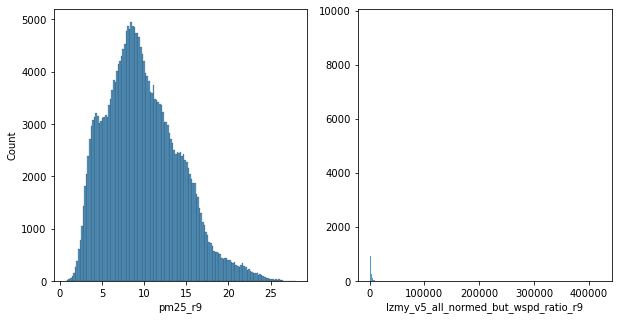

In [1376]:
#columns = ['pm25', 'avg_wind_alignment_cosine']
columns = [target_name_s1, predictor_name_s1]


# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )
    
    if idx in [0]:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel(' ')

``health outcomes``

---
### Step 7: Analysis - linear modeling

``fit ols``

In [1377]:
for col in y_col_names:
    #fit_ols(df_all, col)
    fit_ols(df_all_iv_filtered, col, target_name_s1)

Outcome:  y_visits_hematopoietic_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9,-0.043252,0.015815,-0.075050,-0.011454
1,Intercept,2.061129,0.158483,1.742478,2.379780


Outcome:  y_visits_injuries_accidents
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9,-7.620471,1.395463,-10.421979,-4.818963
1,Intercept,89.385775,14.541584,60.192327,118.579224


Outcome:  y_visits_type_1_diabetes
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9,-0.052415,0.013879,-0.080321,-0.024509
1,Intercept,0.155344,0.149625,-0.145498,0.456186


Outcome:  y_visits_pediatric_vasculitis
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9,-0.008278,0.004857,-0.018055,0.001499
1,Intercept,0.301045,0.052553,0.195261,0.406829


Outcome:  y_visits_resp_cardio
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9,-8.217459,1.399013,-11.026095,-5.408822
1,Intercept,99.348282,14.598079,70.041416,128.655147


``fit first stage``

In [1378]:
# determine whether to include wind in FEs based on instrument
wind_map = set('Izmy_v' + str(i + 1) for i in range(5))
include_wind = predictor[:7] not in wind_map

# create FE and interactions between FE and continous vars
wind = ""

if include_wind:
    wind = ' + avg_wspd_top_15_r' + str(lead_time)

basics = " ~ county + month + year_trend * C(county_month)"
env = ' + avg_temp_r' + str(lead_time) + ' + avg_elevation_diff_m'

f = target_name_s1 + basics + wind + env + adds

print(f)

pm25_r9 ~ county + month + year_trend * C(county_month) + avg_temp_r9 + avg_elevation_diff_m+ ca_agi_per_returns + avg_count_ps_within_5km


In [1379]:
#df_all = fit_1st_stage(df_all, 'pm25', 'avg_wind_alignment_cosine')

df_all_iv_filtered = fit_1st_stage(df_all_iv_filtered, target_name_s1, predictor_name_s1, lead_time)

Outcome:  pm25_r9
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,Izmy_v5_all_normed_but_wspd_ratio_r9,-0.000036,0.000009,-0.000055,-0.000018
1,Intercept,10.072567,1.722036,6.624249,13.520886


R Squared: 0.6851618355249384
p = 0.00018785305036715953



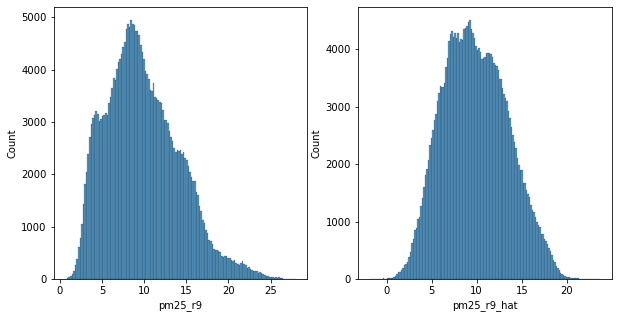

In [1380]:
columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sb.histplot(
            df_all_iv_filtered[columns[idx]],
            ax=ax
        )

First stage F-test:

Run an F test with our instrument to study the impact on the pm2.5. 

In [1381]:
# get data into right model form
# y, X_null = dmatrices('pm25 ~ 1', data=df_all, return_type='dataframe')
# y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df_all, return_type='dataframe')

y, X_null = dmatrices(f'{target_name_s1} ~ 1', data=df_all_iv_filtered, return_type='dataframe')
y, X_instrument = dmatrices(f'{target_name_s1} ~ 1 + {predictor_name_s1}', data=df_all_iv_filtered, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,262449.0,4.934512e+06,0.0,NaN,NaN,NaN
1,262448.0,4.911781e+06,1.0,22731.204524,1214.581705,1.681578e-265


``fit 2sls``

In [1382]:
for col in y_col_names:
    fit_2sls(df_all_iv_filtered, col, target_name_s1+"_hat", lead_time)

y_visits_hematopoietic_cancers ~ county + month + year_trend * C(county_month)+ avg_temp_r9+ avg_elevation_diff_m+ ca_agi_per_returns + avg_count_ps_within_5km
-------------------------------------
Outcome:  y_visits_hematopoietic_cancers
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9_hat,0.599016,0.299087,-0.002339,1.200371
1,Intercept,-4.666809,3.082305,-10.864199,1.530581


R Squared: 0.041122122901978364
p = 0.050862265484623546

y_visits_injuries_accidents ~ county + month + year_trend * C(county_month)+ avg_temp_r9+ avg_elevation_diff_m+ ca_agi_per_returns + avg_count_ps_within_5km
-------------------------------------
Outcome:  y_visits_injuries_accidents
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9_hat,-75.233668,26.266301,-127.965468,-22.501868
1,Intercept,713.113637,286.154645,138.634216,1287.593057


R Squared: 0.06382246091251376
p = 0.0060543079591030315

y_visits_type_1_diabetes ~ county + month + year_trend * C(county_month)+ avg_temp_r9+ avg_elevation_diff_m+ ca_agi_per_returns + avg_count_ps_within_5km
-------------------------------------
Outcome:  y_visits_type_1_diabetes
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9_hat,0.251285,0.415931,-0.584999,1.087570
1,Intercept,-3.754127,4.563679,-12.930019,5.421766


R Squared: 0.03311948408953769
p = 0.5485876096254071

y_visits_pediatric_vasculitis ~ county + month + year_trend * C(county_month)+ avg_temp_r9+ avg_elevation_diff_m+ ca_agi_per_returns + avg_count_ps_within_5km
-------------------------------------
Outcome:  y_visits_pediatric_vasculitis
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9_hat,-0.016226,0.297396,-0.614853,0.582401
1,Intercept,0.485561,3.044822,-5.643348,6.614471


R Squared: 0.02027460923332125
p = 0.9567256025335191

y_visits_resp_cardio ~ county + month + year_trend * C(county_month)+ avg_temp_r9+ avg_elevation_diff_m+ ca_agi_per_returns + avg_count_ps_within_5km
-------------------------------------
Outcome:  y_visits_resp_cardio
-------------------------------------


,variable,coef,std err,[0.025,0.975]
0,pm25_r9_hat,-79.594450,16.618146,-112.956770,-46.232129
1,Intercept,778.904596,181.287375,414.955004,1142.854189


R Squared: 0.030541622638659782
p = 1.479301884062446e-05

